# Parallel Python

In this section we briefly introduce three approaches for parallel computing in Python: `ipyparallel`, `multiprocessing`, and `mpi4py`.

## Contents

- [Why parallelize Python code?](#Why-would-you-want-to-do-parallel-programming-in-Python?)
    - [Before parallelizing Python code](#Before-spending-a-lot-of-time-parallelizing-your-Python-code)
- [Global interpreter lock](#The-global-interpreter-lock-(GIL))
- [IPython for parallel computing](#IPython-for-parallel-computing)
    - [Configuration](#Configuration)
    - [Using `ipyparallel`](#using_ipyparallel)
    - [Example problem](#Example-problem:-inter-city-distances)
    - [Exercise 3.1](#exercise31)
    - [Exercise 3.2](#exercise32)
    - [Exercise 3.3](#exercise33)
- [Multiprocessing](#Multiprocessing)
    - [Exercise 3.4](#exercise34)
    - [Exercise 3.5](#exercise35)
- [MPI4Py](#MPI4Py)
    - [MPI4Py basics](#MPI4Py-basics)
    - [Parallelization via MPI4Py](#Parallelization-via-MPI4Py)
    - [Exercise 3.6](#exercise36)

> Many excellent resources on parallel Python exist on the web, and some have been used as inspiration for the material presented here. In particular, the following resources are recommended:
> - https://github.com/dvalters/RSE18-Python-Parallel-workshop
> - https://swcarpentry.github.io/python-intermediate-mosquitoes/04-multiprocessing.html
> - https://nbviewer.jupyter.org/github/CQuIC/summer17-computing-workshop/blob/master/Parallelization/mpi4py/Introduction_to_MPI4py.ipynb

## Why would you want to do parallel programming in Python? 

Traditionally, Python is considered to not support parallel programming very well, and "proper" parallel programming should be left to "heavy-duty" languages such as Fortran or C/C++ where libraries or standards such as OpenMP and MPI can be utilised. 

For large scale, massively-parallel applications, this is probably still the case, but a rich variety of libraries and packages have been developed outside the core Python language, so parallel programming is now much better supported.

### Before spending a lot of time parallelizing your Python code
- If your Python code is running too slow, there are many ways to speed it up:
    - Begin by identifying the performance bottlenecks in the code - **profile before optimizing!**
    - Use fast numerical packages like [Numpy](http://www.numpy.org/).
    - Use a just-in-time (JIT) compiler like [Numba](https://numba.pydata.org/).
    - Use C-extensions from [Cython](http://cython.org/).
    - Rewrite the performance-critical functions in C/C++/Fortran, and import them into Python.
    - Any of these methods could speed up Python code by orders of magnitude!
- So why bother with parallelizing Python?
    - Perhaps you're already using Numpy, Numba, Cython and/or C/C++/Fortran for the most compute-intensive parts of your code.
    - Perhaps you have a problem that is particularly suitable for parallelization, e.g. a large dataset that can be processed independently in chunks.

## The global interpreter lock (GIL)

- The most common implementation of Python (interpreter/executable that runs your Python code) is called CPython.
- CPython doesn't support using threads well, because it's been written to assume that individual Python programs are serial.
- CPython implements something called the Global Interpreter Lock (GIL) that protects access to Python objects, preventing multiple threads executing Python bytecode through the Python interpreter at once.
- Subsequent developments in Python have come to rely on the GIL being present, so removing it in future versions of Python is unlikely.
- Parallel approaches to Python are normally based around running multiple instances of the Python interpreter, each with its own copy of the the code being run and each with its own separate GIL.

## IPython for parallel computing

IPython abstracts out parallelism in a general way, supporting many different styles of parallelism: Single program multiple data (SPMD) and multiple program multiple data (MPMD) parallelism, message passing using MPI, task farming, data parallel, a combinations of approaches or custom user-defined approaches.

Most importantly, IPython and the `ipyparallel` package enables all types of parallel applications to be developed, executed, debugged, and monitored *interactively*.

The following are some example use cases:

- Quickly parallelize algorithms that are embarrassingly parallel using a number of simple approaches. Many simple things can be parallelized interactively in one or two lines of code.
- Steer traditional MPI applications on a supercomputer from an IPython session on your laptop.
- Analyze and visualize large datasets (that could be remote and/or distributed) interactively using IPython and tools like matplotlib.
- Develop, test and debug new parallel algorithms (that may use MPI) interactively.
- Tie together multiple MPI jobs running on different systems into one giant distributed and parallel system.
- Run a set of tasks on a set of CPUs using dynamic load balancing.

> Adapted from the [official documentation](https://ipyparallel.readthedocs.io/en/)

### Configuration

Already done with jupyter notebook setup, via command `ipython profile create`

<a id='using_ipyparallel'></a>

### Using `ipyparallel`

Starting an IPython cluster for parallel computing can be done from inside Jupyter: 
- Go to the Jupyter dashboard 
- Click the "IPython clusters" tab 
- Choose number of engines (e.g. 4), and click "Start". 

Interacting with the engines is done via the `ipyparallel.Client()` method:  

In [2]:
import ipyparallel as ipp
client = ipp.Client()
print("Number of ipyparallel engines:", len(client.ids))

Number of ipyparallel engines: 4


#### Direct view

The direct view represents one way of working with IPython engines where the capabilities of each engine are directly and explicitly exposed to the user.

We construct a `DirectView` object via list-access to the client:

In [3]:
dview = client[:]
print(dview)

<DirectView [0, 1, 2, 3]>


Suppose we want to calculate the square of 10 integers. We can first define a function and then calculate the squares serially

In [4]:
def square(x):
    return x*x

In [5]:
output = [square(x) for x in range(1,11)]
print(output)

[1, 4, 9, 16, 25, 36, 49, 64, 81, 100]


With `ipyparallel` it is handy to do this via `map_sync`

In [6]:
output = dview.map_sync(square, range(1,11))
print(output)

[1, 4, 9, 16, 25, 36, 49, 64, 81, 100]


The syntax for `map_sync` is straightforward - it accepts the function and a list of input arguments.

#### Load balanced view

The load balanced view is appropriate when you have many jobs that take differnet amounts of time to complete.

In [7]:
lview = client.load_balanced_view()
print(lview)

<LoadBalancedView None>


In [8]:
import numpy as np
lview.map_sync(lambda x: sum(x), np.random.random((10, 100000)))

[50021.40689197971,
 50008.375681112746,
 50101.1951231825,
 50016.5029323747,
 49942.03094366726,
 49999.98532604315,
 50004.585613091534,
 49930.22484286134,
 50146.29493334768,
 49900.06734529308]

### Parallel magic commands

The simplest way to use `ipyparallel` is via the `%px` magic command, which executes code in parallel.

In [10]:
%px import os
%px a = os.getpid()
%px print(a)

[stdout:0] 414435
[stdout:1] 414448
[stdout:2] 414451
[stdout:3] 414455


Let's use the %px magic together with `scatter` and `gather` functions

In [23]:
dview.scatter('xs', range(24))
%px y = [x**2 for x in xs]
%px print(y)

[stdout:0] [0, 1, 4, 9, 16, 25]
[stdout:1] [36, 49, 64, 81, 100, 121]
[stdout:2] [144, 169, 196, 225, 256, 289]
[stdout:3] [324, 361, 400, 441, 484, 529]


In [24]:
np.array(dview.gather('y').get())

array([  0,   1,   4,   9,  16,  25,  36,  49,  64,  81, 100, 121, 144,
       169, 196, 225, 256, 289, 324, 361, 400, 441, 484, 529])

### Example problem: Computing the Mandelbrot set

We will now look at a more compute intensive problem and measure the speedup from using the `@parallel` decorator.

In [25]:
# Serial version
def mandel1(x, y, max_iters=80):
    c = complex(x, y)
    z = 0.0j
    for i in range(max_iters):
        z = z*z + c
        if z.real*z.real + z.imag*z.imag >= 4:
            return i
    return max_iters

In [26]:
# Parallel version using the @parallel decorator
@dview.parallel(block = True)
def mandel2(x, y, max_iters=80):
    c = complex(x, y)
    z = 0.0j
    for i in range(max_iters):
        z = z*z + c
        if z.real*z.real + z.imag*z.imag >= 4:
            return i
    return max_iters

Initialize arrays and meshgrid

In [27]:
x = np.arange(-2, 1, 0.01)
y = np.arange(-1, 1, 0.01)
X, Y = np.meshgrid(x, y)

In [31]:
#%%timeit
im1 = np.reshape(list(map(mandel1, X.ravel(), Y.ravel())), 
                 (len(y), len(x)))

In [33]:
#%%timeit
im2 = np.reshape(mandel2.map(X.ravel(), Y.ravel()),  (len(y), len(x)))

Finally plot the result

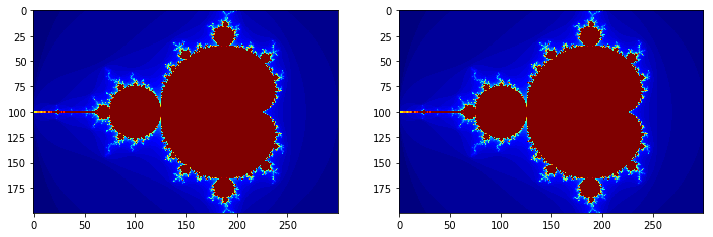

In [34]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].grid(False)
axes[0].imshow(im1, cmap='jet')
axes[1].grid(False)
axes[1].imshow(im2, cmap='jet')
pass

<a id='exercise31'></a>

## Multiprocessing

Another way to run parallel calculation in Python is the `multiprocessing` module, 
which is a built-in module within the core Python modules and does not need any further installation.
We are going to briefly introduce the `Pool` submodule.

Make sure you are still in the `cities` folder.

In [ ]:
%pwd

The processes for the `multiprocessing` module can be started by initializing a `Pool` instance with the number of processes

In [ ]:
import multiprocessing as mp
nprocs = 4
pool = mp.Pool(nprocs)

The `Pool` instance has a `map` function that works similarly to the `map_sync` function from `ipyparallel`.

<a id='exercise34'></a>

### <font color="red"> *Exercise 3.4* </font>

- Using the same function `calc_dist` and dataset `coord_pairs`, provide the function and list of arguments to the `map` function of the `Pool` instance, and time it.

In [ ]:
%%timeit
output = 
print(max(output))

<a id='exercise35'></a>

### <font color="red"> *Exercise 3.5* </font>

- Complete the loop below to perform a scaling test of the `Pool.map` function with the example problem

In [ ]:
for nprocs in range(1,4):
    ___ = __.___(nprocs)
    %timeit output = ___.___(___, ___)

#### Limitation of the `multiprocessing` module:

+ The spawned processes are bound to a single node and therefore not suitable for large-scale parapllelization on distributed memory system.

> The latest documentation for the multiprocessing module is here: https://docs.python.org/3.7/library/multiprocessing.html

## MPI4Py

MPI, the Message Passing Interface, is a standard for parallel programming involving communication between separate parallel processes each with their own separate memory allocation. MPI processes have to pass messages between themselves to invoke code execution and share data between with each other.

### MPI4Py basics

With MPI4Py, it is convenient to obtain the basic MPI settings including the communicator, the rank of the process, and the number of processes.

In [ ]:
from mpi4py import MPI

comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()

MPI4Py also provides convenient communicating functions like `send`, `recv`, `scatter`, `gather`, etc.

There's no automatic mapping but you may find `scatter` and `gather` very useful in practice.

### Parallelization via MPI4Py

Below is an example code of calculating the distances via `mpi4py`.

In [ ]:
import time
from mpi4py import MPI

import dist_cities as dc

# MPI settings

comm = MPI.COMM_WORLD
rank = comm.Get_rank()
nprocs = comm.Get_size()

# prepare data and determine workloads

if rank == 0:
    cities = dc.read_cities()
    coord_pairs = dc.create_coord_pairs(cities)
    npairs = len(coord_pairs)

    dn = npairs // nprocs
    if npairs % nprocs != 0:
        dn += 1

# compute via MPI
# 1. Slice coord_pairs for processes
# 2. Scatter the sliced pieces
# 3. Do computation on each process
# 4. Gather results to master process
# 5. Collect the results into one list

t0 = time.time()

if rank == 0:
    data = [coord_pairs[int(x*dn):int((x+1)*dn)] for x in range(nprocs)]
else:
    data = None

data = comm.scatter(data, root=0)

result = [dc.calc_dist(p) for p in data]

result = comm.gather(result, root=0)

if rank == 0:
    output = []
    for a in result:
        output += a

t1 = time.time()

if rank == 0:
    print("Maximum distance: %.0f km" % max(output))
    print("Computing time: %.3f sec" % (t1-t0))

Note that MPI4Py should be launched by `mpirun`. In the following exercise we'll use the `%salloc` (or `%sbatch`) magic to launch MPI4Py job from the notebook.

<a id='exercise36'></a>

### <font color="red"> *Exercise 3.6* </font>

- Use the `%%writefile` magic to save the code into a `.py` file (e.g. `my_test_mpi.py`).
- Use the `%salloc` magic together with `mpirun` to run the code.


In [ ]:
%salloc -N 1 -t 5 -A edu18.prace --reservation=prace-2018-10-26 mpirun -n 4 python3 my_test_mpi.py